## Excutive Summary

With millions of people around the world today expressing their feelings on products and brands through Yelp reviews, a magnitude of data is available for businesses to track opinions and reactions about their products and services. And as the key indicator of customer satisfaction and experience, sentiment analysis captures critical insights in review content thus drives business success. Such “opinion mining” can not only be used for analysis purposes, but also for predictions.

In this project, I am going to utilize NLP and machine learning technologies to conduct text mining of reviews and predict customers sentimental response towards the Bacchanal Buffet in Las Vegas. Data was from Yelp and consists of 10417 reviews across the Year 2012 to 2019.

## Exploratory Data Analysis

In [ ]:
!pip install langdetect
!pip install textblob 

In [ ]:
#load Library
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

Load the dataset:

In [ ]:
df = pd.read_csv("restaurant.csv")

In [ ]:
df.head(1)

,Unnamed: 0,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,2370338,_WTGv5XnA-qb_XD1D7Z0jg,6PgdGb3HrZdsfl2GiULo8w,RESDUcs7fIiihp38-d6_6g,5,0,1,0,After getting food poisoning at the Palms hote...,2012-12-04 03:10:18


In [ ]:
#check data size
df.shape

(10417, 10)

In [ ]:
#make sure there is no null value to handle
df.isnull().sum()

Unnamed: 0     0
review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64

In [ ]:
#The data constains reviews for only Bacchanal Buffet, so the business id is the same
df.business_id.nunique()

1

In [ ]:
#convert date string to datetime and find the year
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

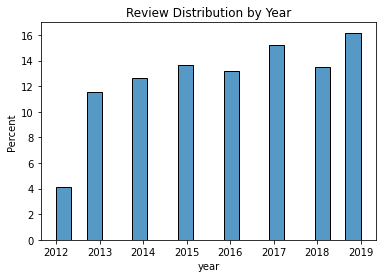

In [ ]:
sns.histplot(x=df['year'],stat='percent')
plt.title("Review Distribution by Year")
plt.show()

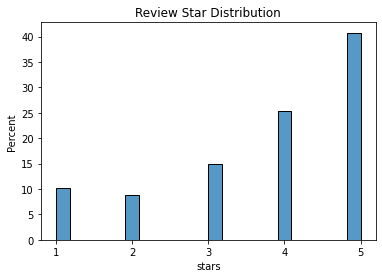

In [ ]:
sns.histplot(x=df['stars'],stat='percent')
plt.title("Review Star Distribution")
plt.xticks(ticks=[1,2,3,4,5])
plt.show()

In [ ]:
from langdetect import detect

In [ ]:
#detect the languages of reviews
df['language'] = df['text'].apply(lambda x:detect(x))

In [ ]:
#See distribution
df['language'].value_counts()

en       10373
es          10
ja           8
zh-cn        7
fr           5
de           4
zh-tw        4
ko           2
da           2
pt           1
sk           1
Name: language, dtype: int64

In [ ]:
#only keep reviews written in English,drop unnamed column and business_id
df = df[df['language']=='en']
df = df.drop(columns=['Unnamed: 0','business_id'])

Dataset Details:
This file has review_id, user_id, business_id, rating stars, useful, funny, cool, review texts and date of the reviews for Las Vegas Bacchanal Buffet. The data has no missing values, consists of 12 languages, with most reviews (10373 records) in English we will analyze. The star rating ranges from 1 to 5, where 1 and 2 indicate negative reviews, 3 for neutral reviews, and 4 and 5 for positive reviews, respectively. Reviews are across the Year 2012 to 2019. 

## Sentimental Analysis

In [ ]:
# Importing essential libraries for performing NLP
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

Clean the reviews, text-Punctuation, remove Stop words

In [ ]:
corpus = []
for i in range(0,df.shape[0]):
  # Cleaning special character from the reviews
  review = re.sub(pattern='[^a-zA-Z]',repl=' ', string=df['text'].iloc[i])
  # Converting the entire review into lower case
  review = review.lower()
  # Tokenizing the review by words
  review_words = review.split()
  # Removing the stop words
  review_words = [word for word in review_words if not word in set(stopwords.words('english'))]
  # Stemming the words
  ps = PorterStemmer()
  review = [ps.stem(word) for word in review_words]
  # Joining the stemmed words
  review = ' '.join(review)
  # Creating a corpus
  corpus.append(review)

In [ ]:
#pass values into review feature
df['review'] = corpus

In [ ]:
#create sentimental feature
df.loc[df['stars'] == 3, 'sentiment'] = 'neutral' 
df.loc[df['stars'] < 3, 'sentiment'] = 'negative' 
df.loc[df['stars'] > 3, 'sentiment'] = 'positive'

In [ ]:
df['sentiment'].value_counts()

positive    6852
negative    1964
neutral     1557
Name: sentiment, dtype: int64

We notice there are 4-5 times positive reviews as negative or neutral reviews. It makes sense because the overall rating of this restaurant is around 4.

In [ ]:
#find most positive and most negative reviews
positive_review = df[df['stars']==5]['review']
negative_review = df[df['stars']==1]['review']

In [ ]:
#load sentimental analysis library
import spacy
from spacy import cli
from textblob import TextBlob

Find polarity and subjectivity score for each review

In [ ]:
df['polarity'] = df['review'].apply(lambda x: TextBlob(x).polarity)
df['subjectivity'] = df['review'].apply(lambda x: TextBlob(x).subjectivity)

Find the relationship between rating stars, usefulness, polarity and subjectivity

In [ ]:
corr = df[['stars','useful','funny','cool','polarity','subjectivity']].corr()

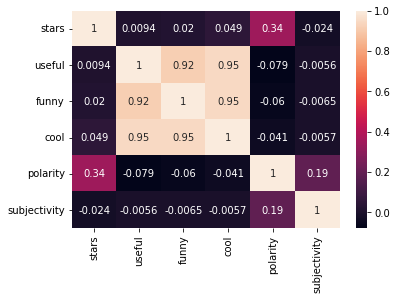

In [ ]:
sns.heatmap(corr,annot=True)

The useful, funny and cool features are closely correlated. People who think the review useful also consider them funny and cool. However, the usefulness does not affect the reviews rating stars, polarity and subjectivity. The R correlation between star rating and polairty is highest but only 0.34.

Text N-gram Analysis: In this case, we are going to set N in the range 1 to 4 text analysis, plot the top frequent words based on sentiment.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
corpus_positive = positive_review.to_list()
corpus_negative = negative_review.to_list()

In [ ]:
ngrams1 = CountVectorizer(ngram_range=(1, 4))
ngrams2 = CountVectorizer(ngram_range=(2, 4))
ngrams_tok_p = ngrams1.fit_transform(corpus_positive)
ngrams_tok_n = ngrams2.fit_transform(corpus_negative)

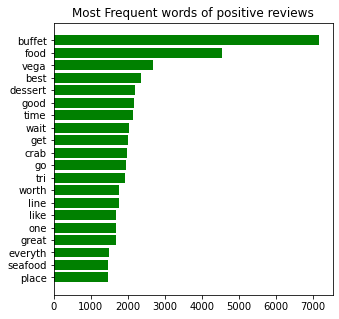

In [ ]:
# zipping actual words and sum of their CountVectorizer for corpus
features_rank = list(zip(ngrams1.get_feature_names(), [x[0] for x in ngrams_tok_p.sum(axis=0).T.tolist()]))
# sorting
features_rank = np.array(sorted(features_rank, key=lambda x:x[1], reverse=True))
n = 20
plt.figure(figsize=(5, 5))
plt.barh(-np.arange(n), features_rank[:n, 1].astype(float), height=.8,color='green')
plt.yticks(ticks=-np.arange(n), labels=features_rank[:n, 0])
plt.title("Most Frequent words of positive reviews")
plt.show()

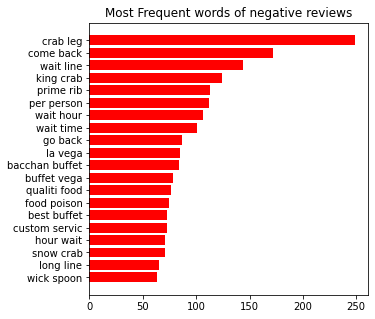

In [ ]:
# zipping actual words and sum of their CountVectorizer for corpus
features_rank = list(zip(ngrams2.get_feature_names(), [x[0] for x in ngrams_tok_n.sum(axis=0).T.tolist()]))
# sorting
features_rank = np.array(sorted(features_rank, key=lambda x:x[1], reverse=True))
n = 20
plt.figure(figsize=(5, 5))
plt.barh(-np.arange(n), features_rank[:n, 1].astype(float), height=.8,color='red')
plt.yticks(ticks=-np.arange(n), labels=features_rank[:n, 0])
plt.title("Most Frequent words of negative reviews")
plt.show()

Word Cloud

In [ ]:
from wordcloud import WordCloud

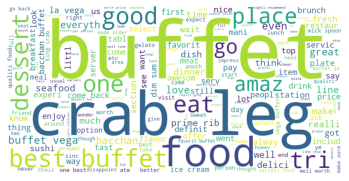

In [ ]:
#positive review word cloud
wordcloud = WordCloud(width = 1000, height = 500, background_color="white").generate(" ".join(positive_review))
# Display the  plot:
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

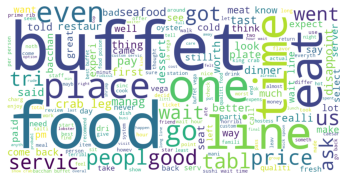

In [ ]:
#negative review word cloud
wordcloud = WordCloud(width = 1000, height = 500, background_color="white").generate(" ".join(negative_review))
# Display the  plot:
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Based on the N-gram analysis and wordcloud plots, we notice that:
* Positive reviewers mention a lot about food such crab leg as dessert and they seem to like flavor of the food.
* Negative reviewers also mention food such as king crab leg, and prime rib and they think the food is good but they concern about the long wait line and wait time.



## Prediction Model (Negative or Positive Sentiment)

In [ ]:
#We only use positive and negative reviews for prediction
data = df[df.sentiment!='neutral']

In [ ]:
data['sentiment'] = data['sentiment'].map({"negative":0,"positive":1})

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
#Creat X and y for model
corpus_model = data['review']
cv = CountVectorizer(max_features=1500)
X = cv.fit_transform(corpus_model).toarray()
y = data['sentiment']

In [ ]:
#Create training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=72,stratify=y)

### Naive Bayes Prediction Model

In [ ]:
# Fitting Naive Bayes to the Training set
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB(alpha=0.2)
nb.fit(X_train, y_train)

MultinomialNB(alpha=0.2)

In [ ]:
y_pred_nb = nb.predict(X_test)

In [ ]:
confusion_matrix(y_test, y_pred_nb)

array([[ 477,  112],
       [ 159, 1897]])

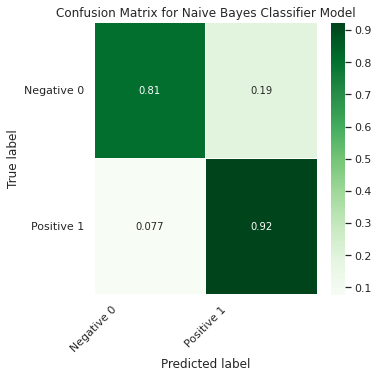

In [ ]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred_nb)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
# Build the plot
plt.figure(figsize=(5,5))
sns.set(font_scale=1)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)
# Add labels to the plot
class_names = ['Negative 0','Positive 1']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Naive Bayes Classifier Model')
plt.show()

### Random Forest Prediction Model

In [ ]:
# Fitting Random Forest to the Training set
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=10,random_state=5,n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=5)

In [ ]:
y_pred_rf = rf.predict(X_test)

In [ ]:
confusion_matrix(y_test, y_pred_rf)

array([[  72,  517],
       [   3, 2053]])

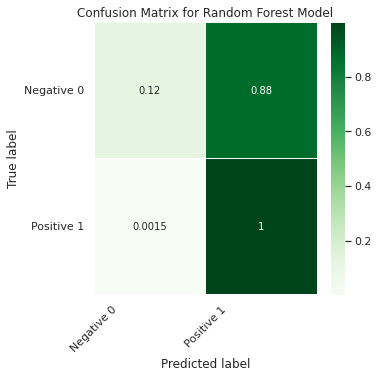

In [ ]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred_rf)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
# Build the plot
plt.figure(figsize=(5,5))
sns.set(font_scale=1)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)
# Add labels to the plot
class_names = ['Negative 0','Positive 1']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

Naive Bayes Model outperformes Random Forest on Sentiment Prediction, with the high accuracy of 81% and 91% for negative and positive sentiment, respectively.

# Summary

In this project, we have successfully conducted sentiment analysis for a Las Vegas buffet Bacchanal Buffet. With a restaurant rating at around 4, we notice there are 4-5 times positive reviews as negative or neutral reviews from the ~10 k reviews. For customers who post reviews in English on Yelp, both positive and negative reviewers like the food, while negative reviewers have a lot of concerns about the long wait line and wait time. This could be because the restaurant is so popular that it is hard to manage busy time. However, the management team should consider come up with strategies to shorten wait time of dining. For example, to show wait time at the cashier or allow customers to register ahead and send text reminder when their table is ready.

We have also built up Naive Bayes Model for sentiment prediction based on their reviews, with the high accuracy of 81% and 91% for negative and positive sentiment, respectively.

# Limitation and Future Work

* We have analyzed reviews in English only, but the customers coming to Las Vegas Buffet are from people all over the word, with limited information, we cannot get a broad picture of the reviews, the data is somehow biased.
* We have conducted N-gram analysis for 1-4 words, which might not enough to capture all useful feedback from customers. Future work could be to increase the range of word length analysis for better understanding of customers.
* We have developed two models, random forest model might perform better with hyper-parameter fine tuning. This could be considered as part of future work.

